In [55]:
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting started with neural networks: Classification and regression

## Classifying movie reviews: A binary classification example

### The IMDB dataset

**Listing 4.1: Loading the IMDB dataset**

In [56]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)
# These are arrays of lists! Ugh

**Listing 4.2: Decoding reviews back to text**

In [57]:
word_index = imdb.get_word_index()
def read_review (review, word_index):
    reverse_word_index = dict(
        [(value, key) for (key, value) in word_index.items()])
    return " ".join(
        [reverse_word_index.get(i - 3, "?") for i in review])
read_review(train_data[1], word_index) # Interesting review

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

### Preparing the data

**Listing 4.3: Encoding the integer sequences via multi-hot encoding**

In [58]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [59]:
utils.tensor_info(x_train, "x_train", image=False)
utils.tensor_info(train_labels, "train_labels")

==================== x_train | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000, 10000) | nDims: 2 | dtype: float64
x_train[0]: [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
... (showing only the first 20 elements)

==================== train_labels | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000,) | nDims: 1 | dtype: int64
Content: [1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]
... (showing only the first 20 elements)



### Building your model

**Listing 4.4: Model definition**

In [60]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [61]:
# PyTorch:
import torch
class TorchModel (torch.nn.Module):
    def __init__(self):
        super().__init__()
        # This layer is lazy, it will only be created when the model is
        # first run. Kind of similar to how Keras works.
        self.fc1 = torch.nn.LazyLinear(16)
        self.fc2 = torch.nn.Linear(16, 16)
        self.fc3 = torch.nn.Linear(16, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

torchmodel = TorchModel()

/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


**Listing 4.5: Compiling the model**

In [62]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [63]:
optimizer = torch.optim.RMSprop(torchmodel.parameters())
loss_fn = torch.nn.BCELoss()

def torchtrain (model, train_dataloader, optimizer, loss_fn):
    model.train() # Set training mode
    total_loss = 0.0
    correct = 0
    samples = 0

    for X, y in train_dataloader:
        # Forward pass
        y_hat = torch.flatten(model(X))
        loss = loss_fn(y_hat, y)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((y_hat.round()) == y).sum().item()
        samples += len(y)
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss, correct / samples # Accuracy and loss

def torchtest (model, test_dataloader, loss_fn):
    model.eval() # Set evaluation mode
    total_loss = 0.0
    correct = 0
    samples = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            y_hat = torch.flatten(model(X))
            loss = loss_fn(y_hat, y)
            total_loss += loss.item()
            correct += ((y_hat.round()) == y).sum().item()
            samples += len(y)
    avg_loss = total_loss / len(test_dataloader.dataset)
    return avg_loss, correct / samples

### Validating your approach

**Listing 4.6: Setting aside a validation set**

In [64]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Or, in scikit:

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=10000)



In [65]:
# Let's build two PyTorch dataloaders to hold the data
train_dataset = []
test_dataset = []
for i in range(len(x_train)):
   train_dataset.append([x_train[i].astype("float32"), y_train[i].astype("float32")])
# Torch wants the features as 32-bit floats.

for i in range(len(x_val)):
   test_dataset.append([x_val[i].astype("float32"), y_val[i].astype("float32")])

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=512)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=512)
utils.tensor_info(train_dataloader, "train_dataloader", image=False)
utils.tensor_info(test_dataloader, "test_dataloader", image=False)

==================== train_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 512 | N batches: 30 
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
features[0]: tensor([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
... (showing only the first 20 elements)

-- First batch of labels
Type: <class 'torch.Tensor'>
Shape: torch.Size([512]) | nDims: 1 | dtype: torch.float32
Content: tensor([1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1.])
... (showing only the first 20 elements)


==================== test_dataloader | tensor_info ====================
Type: <class 'torch.utils.data.dataloader.DataLoader'>
Batch size: 512 | N batches: 20 
-- First batch of features
Type: <class 'torch.Tensor'>
Shape: torch.Size([512, 10000]) | nDims: 2 | dtype: torch.float32
features[0]: tensor([

**Listing 4.7: Training your model**

In [66]:
from tqdm.keras import TqdmCallback
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [67]:
epochs = 4
for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    loss, accu = torchtrain(torchmodel, train_dataloader, optimizer, loss_fn)
    print(f"Train -- Accuracy: {accu} | Loss: {loss}")
    loss, accu = torchtest(torchmodel, test_dataloader, loss_fn)
    print(f"Test -- Accuracy: {accu} | Loss: {loss}")

#TODO: Find a way to print more interesting output that takes less space.

Epoch 1/4
Train -- Accuracy: 0.7004666666666667 | Loss: 0.6445815155903498
Test -- Accuracy: 0.8762 | Loss: 0.0006837785333395004
Epoch 2/4
Train -- Accuracy: 0.8954666666666666 | Loss: 0.2855995575586955
Test -- Accuracy: 0.884 | Loss: 0.0005842626422643661
Epoch 3/4
Train -- Accuracy: 0.9401333333333334 | Loss: 0.1722076043486595
Test -- Accuracy: 0.8887 | Loss: 0.0005652445659041405
Epoch 4/4
Train -- Accuracy: 0.9495333333333333 | Loss: 0.1418688620130221
Test -- Accuracy: 0.8553 | Loss: 0.0008260484576225281


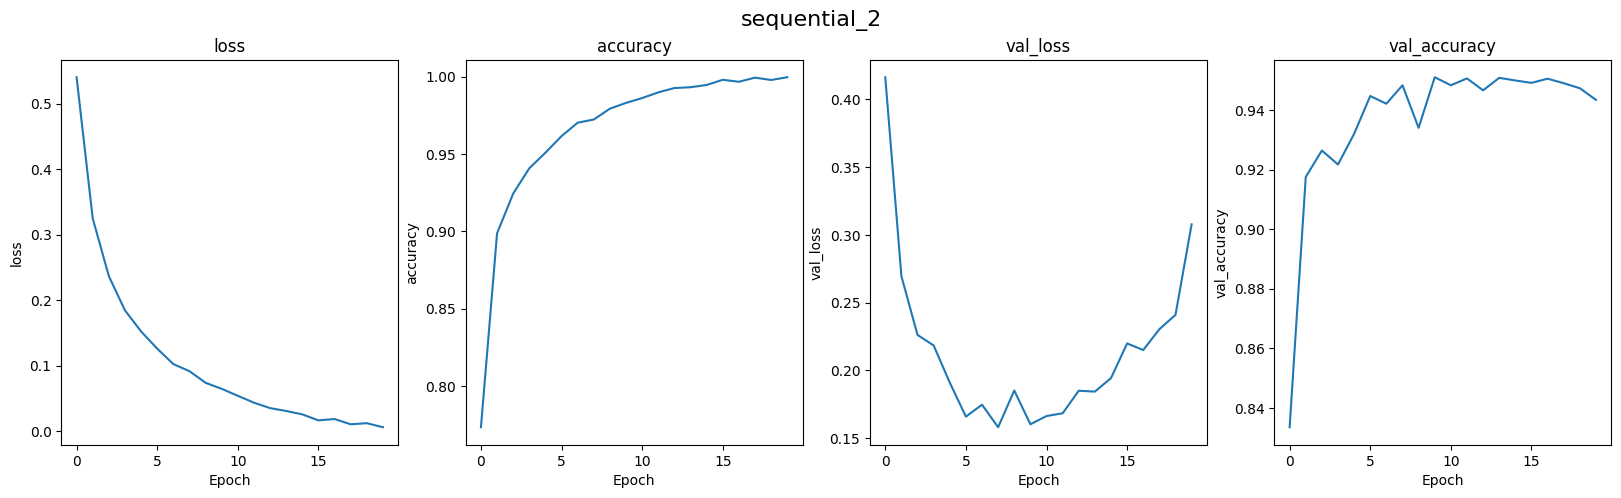

In [68]:
utils.draw_training_history(history)


**Listing 4.8: Plotting the training and validation loss**

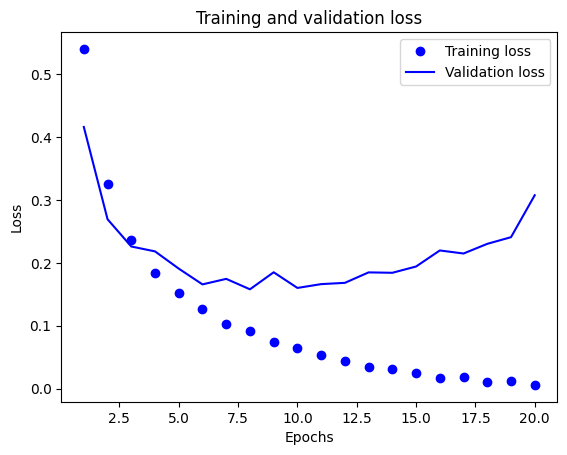

In [69]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Listing 4.9: Plotting the training and validation accuracy**

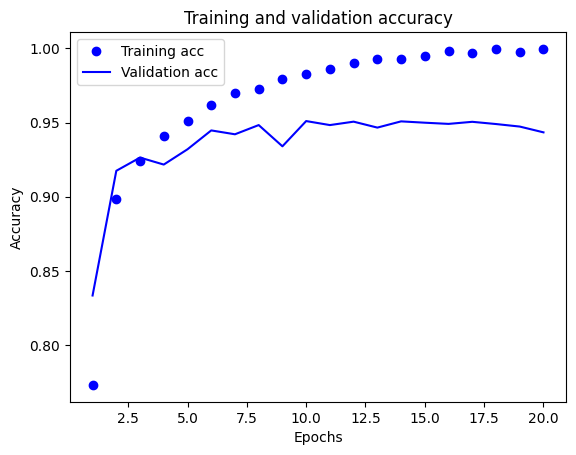

In [70]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Listing 4.10: Retraining a model from scratch**

In [71]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
30/30 [==============================] - 0s 5ms/step - loss: 0.5224 - accuracy: 0.7833
Epoch 2/4
30/30 [==============================] - 0s 5ms/step - loss: 0.3008 - accuracy: 0.9030
Epoch 3/4
30/30 [==============================] - 0s 4ms/step - loss: 0.2189 - accuracy: 0.9264
Epoch 4/4
782/782 [==============================] - 0s 474us/step - loss: 0.2937 - accuracy: 0.8826


In [72]:
results

[0.2936987280845642, 0.8826000094413757]

### Using a trained model to generate predictions on new data

In [73]:
utils.tensor_info(model.predict(x_test), "Keras predictions")

782/782 [==============================] - 0s 454us/step
==================== Keras predictions | tensor_info ====================
Type: <class 'numpy.ndarray'>
Shape: (25000, 1) | nDims: 2 | dtype: float32
Content: [2.5624749e-01 9.9798244e-01 9.4206196e-01 8.3875084e-01 9.1934538e-01
 9.0759528e-01 9.9962550e-01 1.0368936e-02 9.5601565e-01 9.5003116e-01
 9.3120039e-01 7.4392552e-03 2.8094504e-04 2.1331651e-02 9.8169702e-01
 1.6492275e-04 9.5926094e-01 6.8875432e-01 5.2341744e-03 1.0991788e-01]
... (showing only the first 20 elements)



In [89]:
index = 751
print(read_review(train_data[index], word_index))
x = vectorize_sequences([test_data[index]])
yhat = model.predict(x)
print(f"Prediction: {'Positive'if yhat[0] > 0.5 else 'Negative'} | Confidence: {yhat[0]}")

? this is jackie chan's best film and my personal favourite after the disappointing u s made 'the ? directed by james ? jackie took the concept and placed it slap bang into hong kong this is also probably ? most violent movie with the audience cringing at the bone breaking stunts br br the action is fast and furious jackie and his crew really did put max effort into the fight design bones were broken and blood ? in the process of making this film as you'll see in the credits br br the script is a simple cops and robbers affair nothing special after all it was written around the action i must say that the english version has some dodgy dubbing but it shouldn't put you off too much br br so get the ? round crack open the beers and enjoy by the way the film was ? ? ? by the stunt crew why i'll let you find out for yourself
1/1 [==============================] - 0s 10ms/step
Prediction: Positive | Confidence: [0.9332139]


### Further experiments

In [114]:
model1 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model1")
model1.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model2 = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model2")
model2.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model3 = keras.Sequential([
    layers.Dense(16, activation="tanh"),
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model3")
model3.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model4 = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model4")
model4.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model5 = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model5")
model5.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["accuracy"])

model6 = keras.Sequential([
    layers.Dense(16, activation="tanh"),
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
], name="model6")
model6.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


==================== Comparing 6 Keras models ====================
Epochs: 10 | Batch size: 512

Training model 'model1' with 160305 parameters
Training took: 7.07423 s


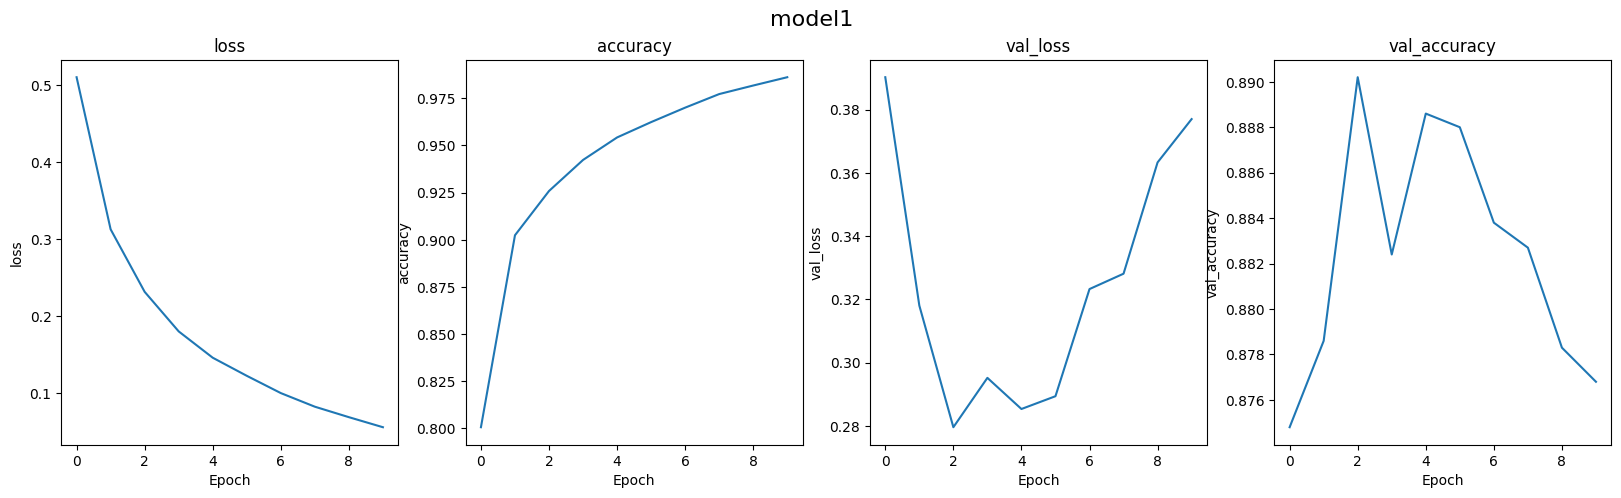

Testing evaluation for model 'model1':
loss: 0.41081953048706055
accuracy: 0.8649600148200989

Training model 'model2' with 320065 parameters
Training took: 6.79538 s


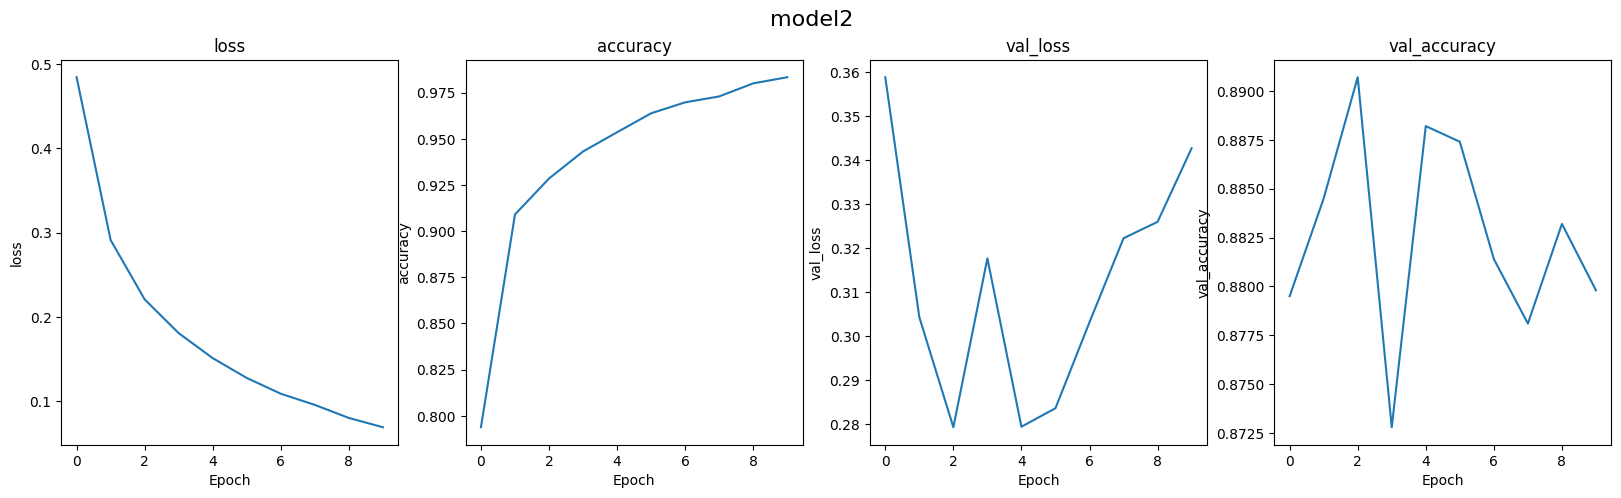

Testing evaluation for model 'model2':
loss: 0.37007907032966614
accuracy: 0.8686400055885315

Training model 'model3' with 160305 parameters
Training took: 5.35418 s


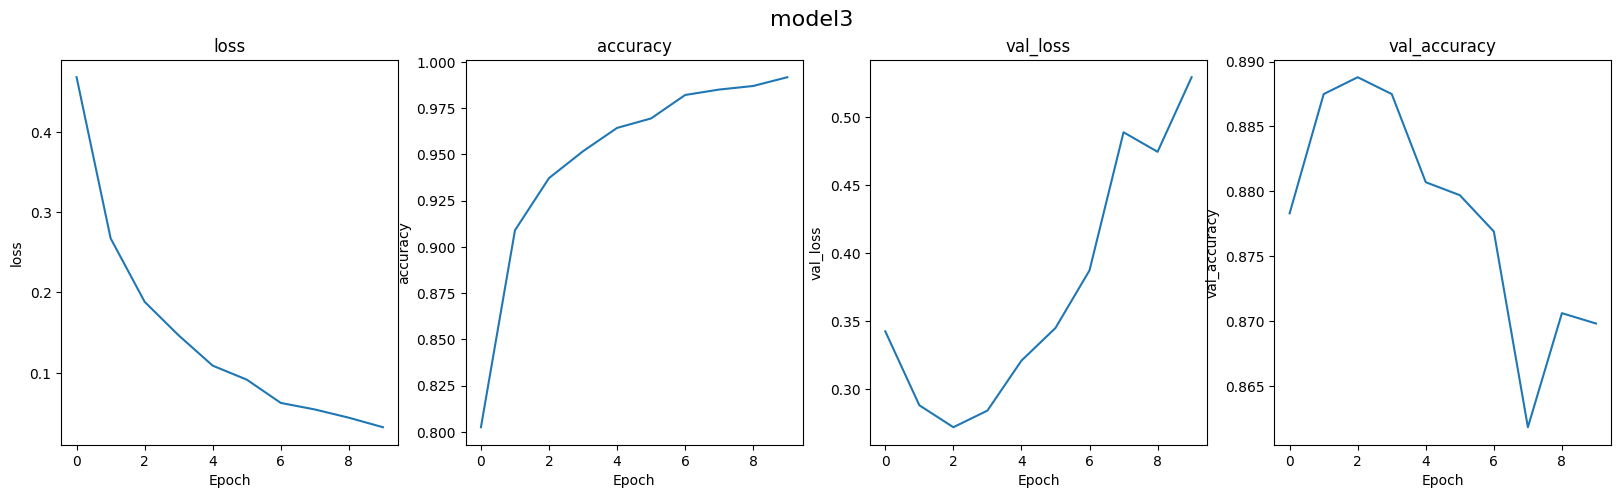

Testing evaluation for model 'model3':
loss: 0.592485249042511
accuracy: 0.8514800071716309

Training model 'model4' with 160305 parameters
Training took: 4.64645 s


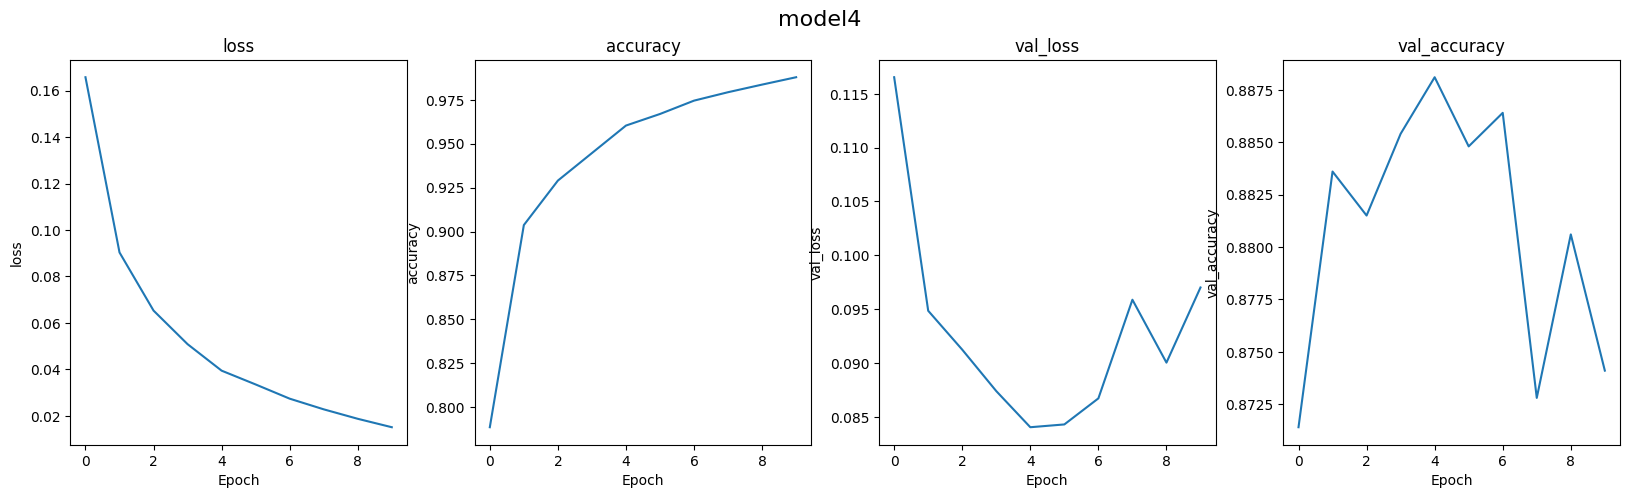

Testing evaluation for model 'model4':
loss: 0.10463236272335052
accuracy: 0.8638399839401245

Training model 'model5' with 320065 parameters
Training took: 4.89498 s


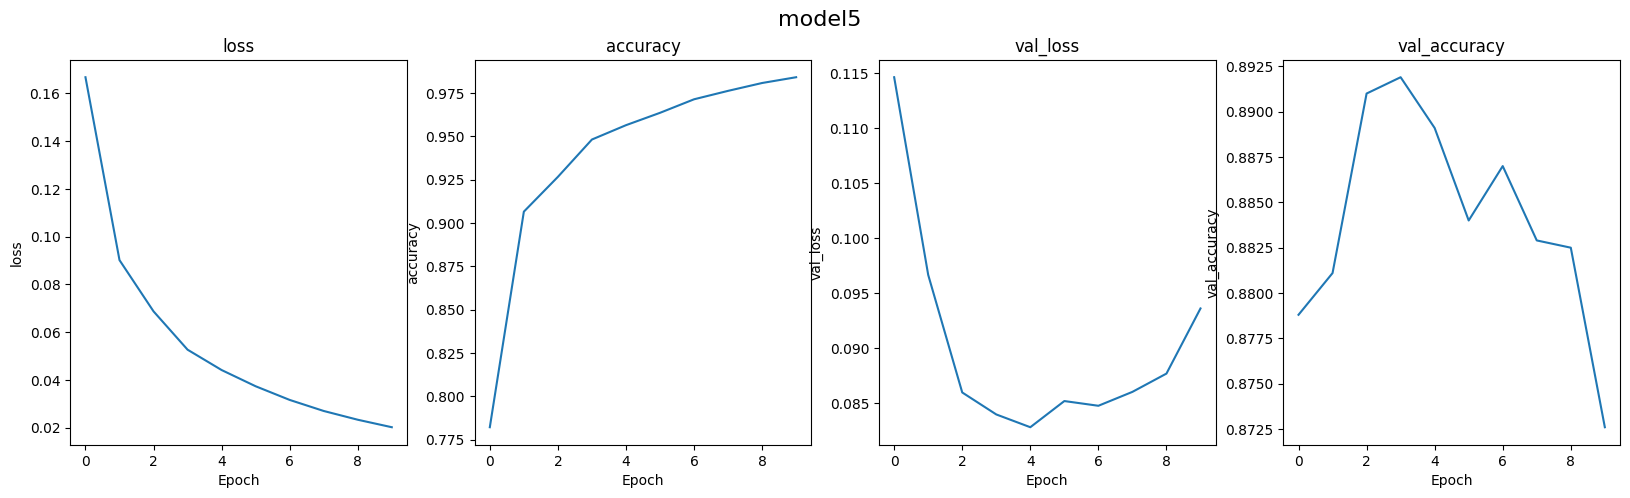

Testing evaluation for model 'model5':
loss: 0.1035761907696724
accuracy: 0.862280011177063

Training model 'model6' with 160305 parameters
Training took: 4.15143 s


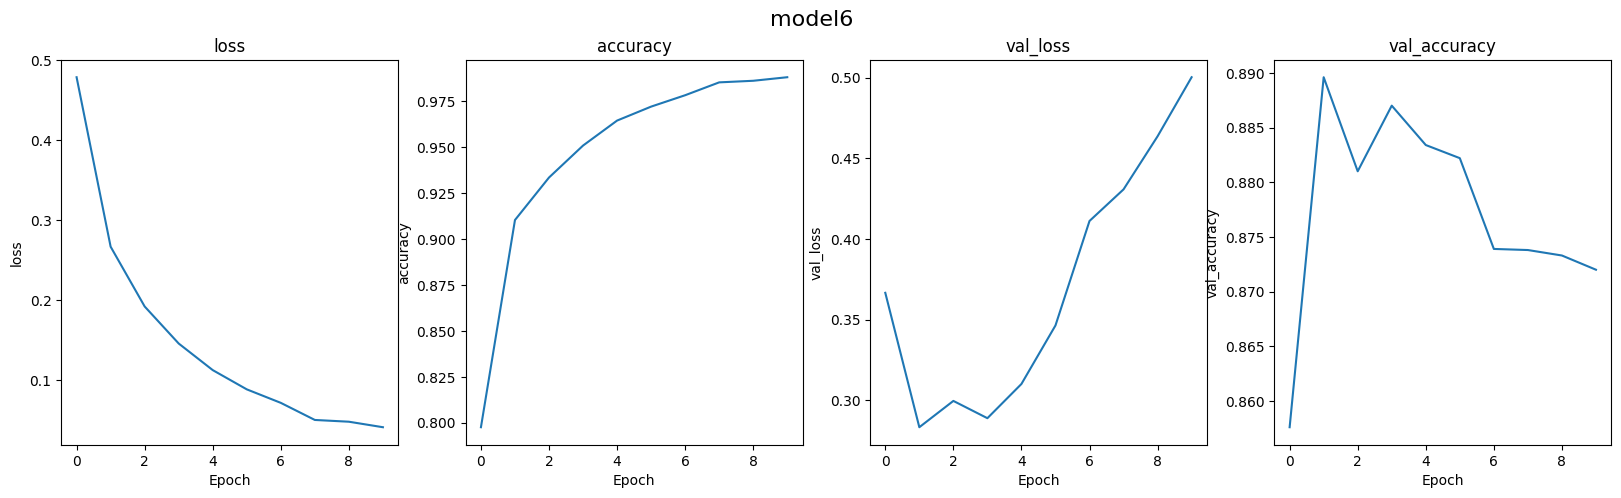

Testing evaluation for model 'model6':
loss: 0.552487313747406
accuracy: 0.8567600250244141


In [115]:
utils.keras_comparer([model1, model2, model3, model4, model5, model6], X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test, val_data=(x_val, y_val), epochs=10, batch_size=512)

### Wrapping up

## Classifying newswires: A multiclass classification example

### The Reuters dataset

**Loading the Reuters dataset**

In [ ]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
train_data[10]

**Decoding newswires back to text**

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

In [ ]:
train_labels[10]

### Preparing the data

**Encoding the input data**

In [ ]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

**Model definition**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**Compiling the model**

In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Training the model**

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

**Plotting the training and validation loss**

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [ ]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

In [ ]:
results

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

### Generating predictions on new data

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions[0].shape

In [ ]:
np.sum(predictions[0])

In [ ]:
np.argmax(predictions[0])

### A different way to handle the labels and the loss

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
train_data.shape

In [ ]:
test_data.shape

In [ ]:
train_targets

### Preparing the data

**Normalizing the data**

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [ ]:
all_scores

In [ ]:
np.mean(all_scores)

**Saving the validation logs at each fold**

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
test_mae_score

### Generating predictions on new data

In [ ]:
predictions = model.predict(test_data)
predictions[0]

### Wrapping up

## Summary